### Imports and loadings

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.colors as mcolors
from pycountry_convert import country_alpha2_to_country_name, country_name_to_country_alpha3
from scipy.stats import pearsonr
from weighted_counts import weighted_value_counts,weighted_country_value_counts
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

#color palette
colormap_clmchng = ['#0474BA','#00A7E1', '#FFA630', '#F17720']
colormap_clmchng_r = colormap_clmchng.copy(); colormap_clmchng_r.reverse()
colormap_ccnthum = ['#32c377','#009f95','#0076a3','#004b92','#041c62']
colormap_ccrdprs = ['#c37732', '#c35a32','#bc4742','#af3750','#9c2e5c','#832b65','#672c69','#462c68','#202b62','#101041','#08042a']

#import csv
df_full = pd.read_csv('./ESS8e02.1_F1.csv',low_memory=False)

Since Pandas values_count() doensn't seem to support a weighted count I have rewrited two versions of this function.

In [4]:
{
    "tags": [
        "hide-input",
    ]
}

def weighted_value_counts(df_col,w):
    labels = [np.NaN]
    counts = [0]

    l_w = list(w)

    for o,obs in enumerate(df_col):

        #count
        w_count = l_w[o]

        if np.isnan(obs):
            #update count
            counts[0] += w_count
        else:
            #if new append label and count
            if not obs in labels:
                labels.append(obs)
                counts.append(w_count)
            else:
                #update count
                counts[labels.index(obs)] += w_count

    return pd.Series(counts, index=labels, name=df_col.name)

def weighted_country_value_counts(df_country_col1, df_col2,w):
    labels1 = [np.NaN]
    labels2 = [np.NaN]
    counts = [0]

    l_col2 = list(df_col2)
    l_w = list(w)

    for o1,obs1 in enumerate(df_country_col1):
        
        #col2
        obs2 = l_col2[o1]

        #count
        w_count = l_w[o1]

        if np.isnan(obs2):
            #update count
            counts[0] += w_count
        else:
            #if new append labels and count
            if (not obs1 in labels1) or (not obs2 in labels2) or not(obs2 in [labels2[i] for i in [i for i, x in enumerate(labels1) if x == obs1]]):
                labels1.append(obs1)
                labels2.append(obs2)
                counts.append(w_count)
            else:
                #print(labels1);print(labels2);print(counts);print(obs1);print(obs2)
                count_indx = list(set([i for i, x in enumerate(labels1) if x == obs1]).intersection([i for i, x in enumerate(labels2) if x == obs2]))
                #update count
                counts[count_indx[0]] += w_count

    return pd.Series(counts, index=[labels1,labels2])   #name={df_country_col1.name,df_col2.name}

### Analysis

In [5]:
#The dataset is big, we only need a portion of it
df = df_full[['cntry','pspwght','pweight','clmchng','ccnthum','ccrdprs']]
# cntry: country, pspwght: post-stratification weight, pweight: population weight
# clmchng: World's climate is changing? 1:Yes 4:No >4:null
# ccnthum: Climate change is caused by nature or human activity? 1:Nature 5:Human >5:null
# ccrdprs: Personal responsibility to try to reduce climate change? 0:No 10:Yes >10:null

#add a new column as the combination between post-stratification weights and population weights
df['anwght'] = df['pspwght'] * df['pweight']

#consider "Not applicable", "Refusal", "Don't know", "No answer" and other answers as missing values 
df['clmchng'].replace(dict.fromkeys([7,8,9],np.NaN),inplace=True) 
df['ccnthum'].replace(dict.fromkeys([55,66,77,88,99],np.NaN),inplace=True)
df['ccrdprs'].replace(dict.fromkeys([66,77,88,99],np.NaN),inplace=True)

df.head()

,cntry,pspwght,pweight,clmchng,ccnthum,ccrdprs,anwght
0,AT,1.178496,0.370393,1.0,4.0,8.0,0.436506
1,AT,0.899472,0.370393,1.0,4.0,7.0,0.333158
2,AT,0.315753,0.370393,1.0,4.0,8.0,0.116953
3,AT,0.472467,0.370393,2.0,3.0,6.0,0.174999
4,AT,2.246706,0.370393,1.0,4.0,6.0,0.832164


#### Looking behind the consensus

What is the proportion of people recognizing climate change? (answers 1 or 2)

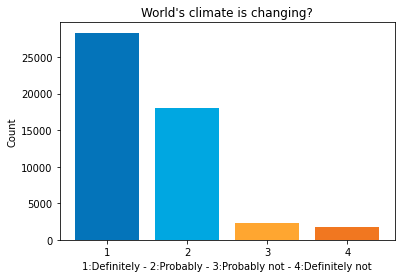

In [6]:
#plot a bar chart
clmchng_w_count = weighted_value_counts(df['clmchng'],df['anwght'])[1:]
plt.bar(sorted(df['clmchng'].unique().astype(int))[1:],clmchng_w_count, color=colormap_clmchng)
plt.title("World's climate is changing?")
plt.ylabel("Count")
plt.xlabel("1:Definitely - 2:Probably - 3:Probably not - 4:Definitely not")
plt.xticks(sorted(df['clmchng'].unique().astype(int))[1:]);

The proportion of people recognizing climate change is: 91.9%


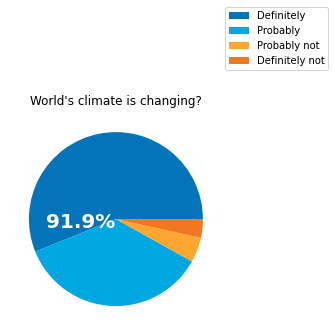

In [7]:
#plot a pie chart
clmchng_yes = round(clmchng_w_count[1:2].sum() / clmchng_w_count.sum() *100,1)
plt.pie(clmchng_w_count,colors=colormap_clmchng);
plt.annotate(text=str(clmchng_yes)+"%", xy=(-0.8,-0.1), weight='bold', fontsize=20, color='white');
plt.title("World's climate is changing?");
plt.legend(["Definitely", "Probably" ,"Probably not","Definitely not"], loc='upper right',bbox_to_anchor=(1.5, 1.5));
print("The proportion of people recognizing climate change is: " +str(clmchng_yes)+ "%")

Among the precedent group, what is the proportion of people recognizing human origins of climate change? (answers 4 or 5)

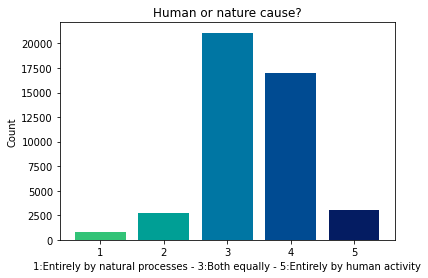

In [8]:
#plot a bar chart
df_91_9 = df[df['clmchng'].isin([1,2])] #select the precedent sub-group
ccnthum91_9_w_count = weighted_value_counts(df_91_9['ccnthum'],df['anwght']).sort_index().drop(np.NaN)
plt.bar(sorted(df_91_9['ccnthum'].unique().astype(int))[1:],ccnthum91_9_w_count, color=colormap_ccnthum)
plt.title("Human or nature cause?")
plt.ylabel("Count")
plt.xlabel("1:Entirely by natural processes - 3:Both equally - 5:Entirely by human activity")
plt.xticks(sorted(df_91_9['ccnthum'].unique().astype(int))[1:]);

Among the precedent group, the proportion of people recognizing human origins of climate change is: 44.8%


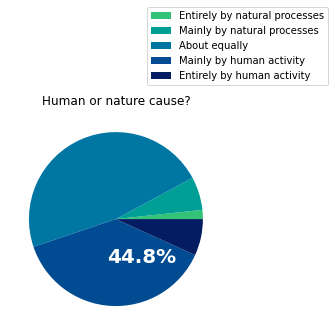

In [9]:
#plot a pie chart
ccnthum91_9_yes = round(ccnthum91_9_w_count[4:5].sum() / ccnthum91_9_w_count.sum() *100,1)
plt.pie(ccnthum91_9_w_count,colors=colormap_ccnthum);
plt.annotate(text=str(ccnthum91_9_yes)+"%", xy=(-0.1,-0.5), weight='bold', fontsize=20, color='white');
plt.title("Human or nature cause?");
plt.legend(["Entirely by natural processes", "Mainly by natural processes" ,"About equally","Mainly by human activity", "Entirely by human activity"], loc='upper right',bbox_to_anchor=(1.5, 1.5));
print("Among the precedent group, the proportion of people recognizing human origins of climate change is: " +str(ccnthum91_9_yes)+ "%")

Among the precedent group, what is the proportion of people feeling a personal responsibility to try to reduce climate change? (answers >6)

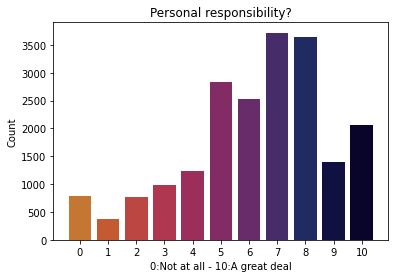

In [10]:
#plot a bar chart
df_44_8 = df_91_9[df_91_9['ccnthum'].isin([4,5])] #select the precedent sub-group
ccrdprs44_8_w_count = weighted_value_counts(df_44_8['ccrdprs'],df['anwght']).sort_index().drop(np.NaN)
plt.bar(sorted(df_44_8['ccrdprs'].unique().astype(int))[1:],ccrdprs44_8_w_count, color=colormap_ccrdprs)
plt.title("Personal responsibility?")
plt.ylabel("Count")
plt.xlabel("0:Not at all - 10:A great deal")
plt.xticks(sorted(df_44_8['ccrdprs'].unique().astype(int))[1:]);

Among the precedent group, the proportion of people feeling a personal responsibility to try to reduce climate change is: 53.2%


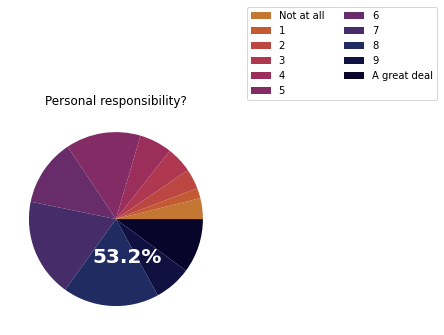

In [11]:
#plot a pie chart
ccrdprs44_8_yes = round(ccrdprs44_8_w_count[7:10].sum() / ccrdprs44_8_w_count.sum() *100,1)
plt.pie(ccrdprs44_8_w_count,colors=colormap_ccrdprs);
plt.annotate(text=str(ccrdprs44_8_yes)+"%", xy=(-0.27,-0.5), weight='bold', fontsize=20, color='white');
plt.title("Personal responsibility?");
plt.legend(["Not at all", "1","2" ,"3","4", "5", "6", "7", "8", "9", "A great deal"], loc='upper right',bbox_to_anchor=(2, 1.5), ncol=2);
print("Among the precedent group, the proportion of people feeling a personal responsibility to try to reduce climate change is: " +str(ccrdprs44_8_yes)+ "%")

#### Is it the same everywhere?

In [12]:
#count the values separately for each country
clmchng_weighted_count = weighted_country_value_counts(df['cntry'],df['clmchng'],df['pspwght']).drop(np.NaN).sort_index()
df_yes_clmchng = df[df['clmchng'].isin([1,2])]  #select the precedent sub-group
ccnthum_weighted_count = weighted_country_value_counts(df_yes_clmchng['cntry'],df_yes_clmchng['ccnthum'],df_yes_clmchng['pspwght']).drop(np.NaN).sort_index()
df_yes_ccnthum = df_yes_clmchng[df_yes_clmchng['ccnthum'].isin([4,5])]  #select the precedent sub-group
ccrdprs_weighted_count = weighted_country_value_counts(df_yes_ccnthum['cntry'],df_yes_ccnthum['ccrdprs'],df_yes_ccnthum['pspwght']).drop(np.NaN).sort_index()

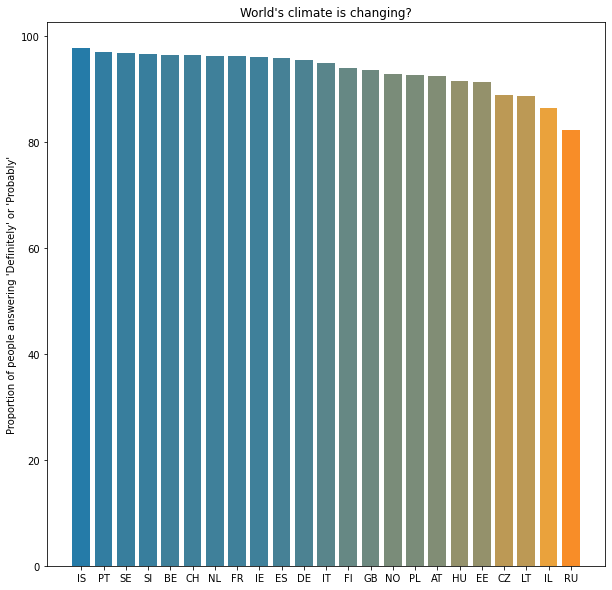

In [13]:
#count the proportion of people recognizing climate change in each country
clmchng_yes_countries = []
for c,country in enumerate(df['cntry'].unique()):
    c_w_count = clmchng_weighted_count[country]
    clmchng_yes_countries.append(round(c_w_count[1:2].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
colormap_clmchng = ['#0474BA','#00A7E1', '#FFA630', '#F17720']
clist = [(0, colormap_clmchng[3]), (0.8, colormap_clmchng[3]), (0.85,colormap_clmchng[2]),(1, colormap_clmchng[0])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(clmchng_yes_countries))

#plot bar chart
plt.figure(figsize=(10,10))
plt.bar(df['cntry'].unique()[sort_id],sorted(clmchng_yes_countries, reverse=True), color=rvb(np.array(sorted(clmchng_yes_countries, reverse=True))/100));
plt.title("World's climate is changing?")
plt.ylabel("Proportion of people answering 'Definitely' or 'Probably'");

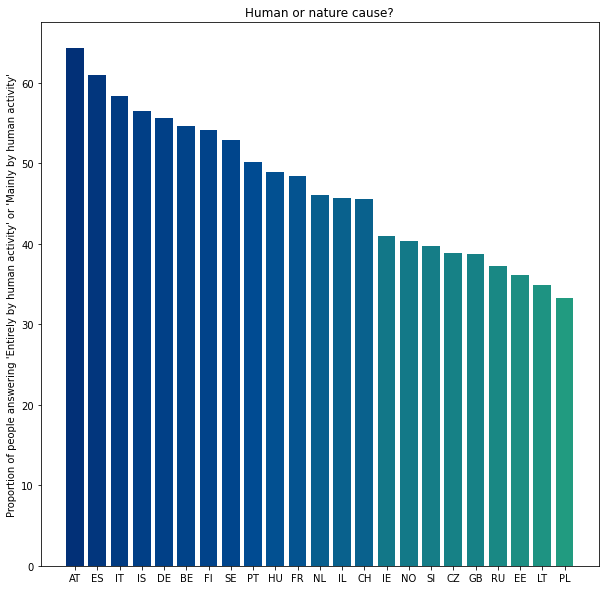

In [14]:
#count the proportion of people recognizing human origins of climate change
ccnthum_yes_countries = []
for c,country in enumerate(df_yes_clmchng['cntry'].unique()):
    c_w_count = ccnthum_weighted_count[country]
    ccnthum_yes_countries.append(round(c_w_count[4:5].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
clist = [(0, colormap_ccnthum[0]), (0.25, colormap_ccnthum[0]), (0.50, colormap_ccnthum[3]),(0.75,colormap_ccnthum[4]),(1, colormap_ccnthum[4])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(ccnthum_yes_countries))

#plot bar chart
plt.figure(figsize=(10,10))
plt.bar(df_yes_clmchng['cntry'].unique()[sort_id],sorted(ccnthum_yes_countries, reverse=True), color=rvb(np.array(sorted(ccnthum_yes_countries, reverse=True))/100));
plt.title("Human or nature cause?")
plt.ylabel("Proportion of people answering 'Entirely by human activity' or 'Mainly by human activity'");

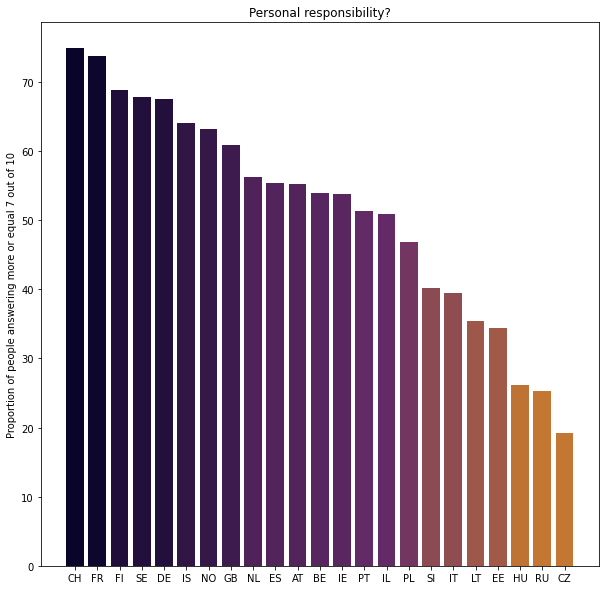

In [15]:
#count the proportion of people feeling a personal responsibility to try to reduce climate change
ccrdprs_yes_countries = []
for c,country in enumerate(df_yes_ccnthum['cntry'].unique()):
    c_w_count = ccrdprs_weighted_count[country]
    ccrdprs_yes_countries.append(round(c_w_count[7:].sum() / c_w_count.sum() *100,1))

#create a continuous colormap from previous discrete colormap
clist = [(0, colormap_ccrdprs[0]), (0.25, colormap_ccrdprs[0]), (0.50, colormap_ccrdprs[6]),(0.75,colormap_ccrdprs[10]),(1, colormap_ccrdprs[10])]
rvb = mcolors.LinearSegmentedColormap.from_list("", clist)

#order countries in descending order
sort_id = np.argsort(-np.array(ccrdprs_yes_countries))

#plot bar chart
plt.figure(figsize=(10,10))
plt.bar(df_yes_ccnthum['cntry'].unique()[sort_id],sorted(ccrdprs_yes_countries, reverse=True), color=rvb(np.array(sorted(ccrdprs_yes_countries, reverse=True))/100));
plt.title("Personal responsibility?");
plt.ylabel("Proportion of people answering more or equal 7 out of 10");

In [16]:
#build a dataframe where for each country it is stored the proportion of "yes" to the three initial questions.
yes_map = pd.DataFrame({'cntry':df['cntry'].unique(),'clmchng_yes':clmchng_yes_countries, 'ccnthum_yes':ccnthum_yes_countries, 'ccrdprs_yes':ccrdprs_yes_countries})

#convert country codes from 2 letters to 3 letters (necessary for plotly)
yes_map['country_alpha_3'] = yes_map.cntry.apply(lambda x: country_name_to_country_alpha3(country_alpha2_to_country_name(x)))
yes_map

,cntry,clmchng_yes,ccnthum_yes,ccrdprs_yes,country_alpha_3
0,AT,92.5,64.3,55.3,AUT
1,BE,96.4,54.6,54.0,BEL
2,CH,96.4,45.5,74.9,CHE
3,CZ,88.9,38.8,19.2,CZE
4,DE,95.5,55.6,67.6,DEU
5,EE,91.3,36.1,34.4,EST
6,ES,95.8,61.0,55.4,ESP
7,FI,94.0,54.1,68.9,FIN
8,FR,96.3,48.4,73.7,FRA
9,GB,93.6,38.7,60.9,GBR


In [17]:
#plot a map with the proportion of people recognizing climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='clmchng_yes', projection='natural earth'
, color_continuous_scale=colormap_clmchng_r, title="World's climate is changing?", width=500, height=400)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

In [18]:
#plot a map with the proportion of people recognizing human origins of climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='ccnthum_yes', projection='natural earth'
, color_continuous_scale=colormap_ccnthum, title="Human or nature cause?", width=500, height=400)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

In [19]:
#plot a map with the proportion of people feeling a personal responsibility to try to reduce climate change in each country as a colorcode
fig = px.choropleth(yes_map, locationmode= 'ISO-3',locations='country_alpha_3', color='ccrdprs_yes', projection='natural earth'
, color_continuous_scale=colormap_ccrdprs, title="Personal responsibility?", width=500, height=400)
fig.update_geos(center=dict(lon=10, lat=55),
    lataxis_range=[0,55], lonaxis_range=[0, 80])
fig.show()

#### Correlations?

In [20]:
#compute pearson correlations
corr_ch = pearsonr(yes_map['clmchng_yes'],yes_map['ccnthum_yes'])
corr_hr = pearsonr(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'])
corr_cr = pearsonr(yes_map['clmchng_yes'],yes_map['ccrdprs_yes'])

#store correlation r
ch_r = round(corr_ch[0],2)
hr_r = round(corr_hr[0],2)
cr_r = round(corr_cr[0],2)

print(f"Change-Human correlation: R={ch_r}, p_value={round(corr_ch[1],2)}")
print(f"Change-Human correlation: R={hr_r}, p_value={round(corr_hr[1],2)}")
print(f"Change-Human correlation: R={cr_r}, p_value={round(corr_cr[1],2)}")

Change-Human correlation: R=0.46, p_value=0.03
Change-Human correlation: R=0.42, p_value=0.05
Change-Human correlation: R=0.64, p_value=0.0


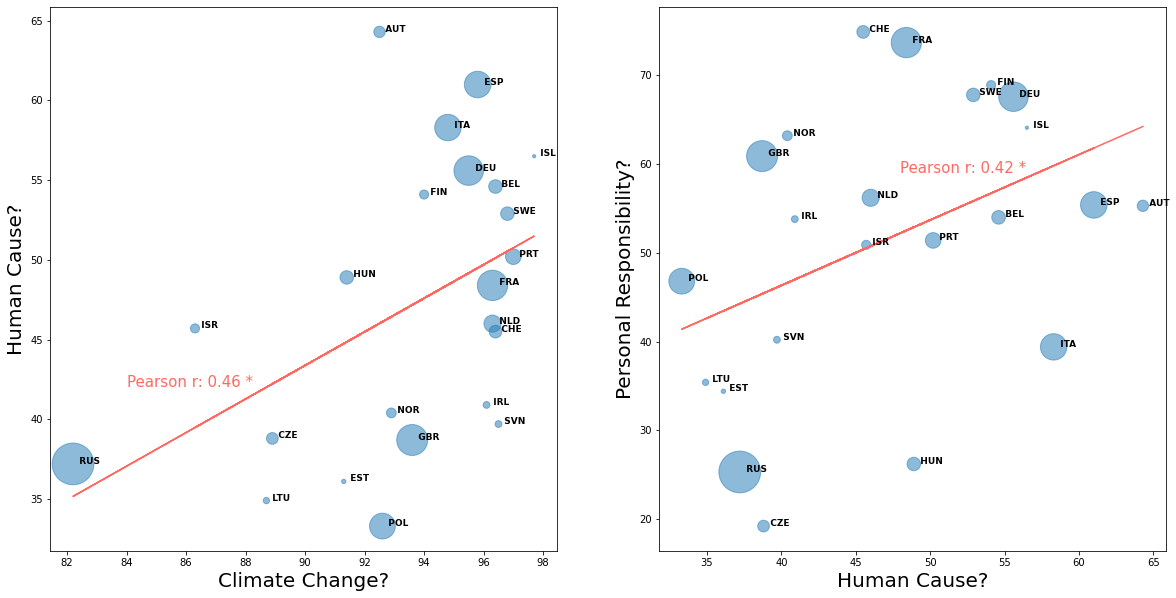

In [21]:
#extract array with a measure of the population size of each country
cntry_size = df[['cntry','pweight']].groupby('cntry').mean()

#build a scatter plot with regressions lines
fig, axs = plt.subplots(1,2,figsize=(20,10))
axs[0].scatter(yes_map['clmchng_yes'],yes_map['ccnthum_yes'], s=cntry_size['pweight']*350, alpha=0.5); axs[0].set_xlabel("Climate Change?", fontsize=20); axs[0].set_ylabel("Human Cause?", fontsize=20); m, b = np.polyfit(yes_map['clmchng_yes'],yes_map['ccnthum_yes'], 1); axs[0].plot(yes_map['clmchng_yes'], m*yes_map['clmchng_yes'] + b, color='#FF6962'); axs[0].annotate("Pearson r: " + str(ch_r) + " *", (84,42), color='#FF6962', fontsize=15);
axs[1].scatter(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'], s=cntry_size['pweight']*350, alpha=0.5); axs[1].set_xlabel("Human Cause?", fontsize=20); axs[1].set_ylabel("Personal Responsibility?", fontsize=20); m, b = np.polyfit(yes_map['ccnthum_yes'],yes_map['ccrdprs_yes'], 1); axs[1].plot(yes_map['ccnthum_yes'], m*yes_map['ccnthum_yes'] + b, color='#FF6962'); axs[1].annotate("Pearson r: " + str(hr_r) + " *", (48,59), color='#FF6962', fontsize=15);
for i,txt in enumerate(yes_map['country_alpha_3']):
    axs[0].annotate("  " +str(txt), (yes_map['clmchng_yes'][i],yes_map['ccnthum_yes'][i]), size=9, weight='bold')
    axs[1].annotate("  " +str(txt), (yes_map['ccnthum_yes'][i],yes_map['ccrdprs_yes'][i]), size=9, weight='bold')

#### Are there predictors of these beliefs?

In [22]:
from sklearn.model_selection import train_test_split
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [23]:
#Extract a new sub-set of the full dataset
df_reg = df_full[['clmchng','ccnthum','ccrdprs','agea','eduyrs','netustm','nwspol','wkhct']]

#consider "Not applicable", "Refusal", "Don't know", "No answer" and other answers as missing values 
df_reg['clmchng'].replace(dict.fromkeys([7,8,9],np.NaN),inplace=True) 
df_reg['ccnthum'].replace(dict.fromkeys([55,66,77,88,99],np.NaN),inplace=True)
df_reg['ccrdprs'].replace(dict.fromkeys([66,77,88,99],np.NaN),inplace=True)
df_reg['agea'].replace(999,np.NaN,inplace=True)
df_reg['eduyrs'].replace(dict.fromkeys([77,88,99],np.NaN),inplace=True)
df_reg['netustm'].replace(dict.fromkeys([6666,7777,8888,9999],np.NaN),inplace=True)
df_reg['nwspol'].replace(dict.fromkeys([7777,8888,9999],np.NaN),inplace=True)
df_reg['wkhct'].replace(dict.fromkeys([666,777,888,999],np.NaN),inplace=True)

df_reg.head()

,clmchng,ccnthum,ccrdprs,agea,eduyrs,netustm,nwspol,wkhct
0,1.0,4.0,8.0,34.0,21.0,180.0,120.0,25.0
1,1.0,4.0,7.0,52.0,16.0,120.0,120.0,NaN
2,1.0,4.0,8.0,68.0,13.0,NaN,30.0,38.0
3,2.0,3.0,6.0,54.0,12.0,120.0,30.0,40.0
4,1.0,4.0,6.0,20.0,13.0,180.0,30.0,40.0


In [24]:
#define dataframe where rows containing nans in the 'clmchng' columns are dropped
df_reg_cc = df_reg.dropna(subset=['clmchng'],axis=0)
#reverse the scores to be coherent with the other two questions: higher score means more recognition to climate change
df_reg_cc['clmchng'] = -df_reg_cc['clmchng']

#define dataframe where rows containing nans in the 'ccnthum' columns are dropped
df_reg_ch = df_reg.dropna(subset=['ccnthum'],axis=0)

#define dataframe where rows containing nans in the 'ccrdprs' columns are dropped
df_reg_pr = df_reg.dropna(subset=['ccrdprs'],axis=0)

Optimization terminated successfully.
         Current function value: 0.911958
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 1.164544
         Iterations: 26
         Function evaluations: 29
         Gradient evaluations: 29
Optimization terminated successfully.
         Current function value: 2.256977
         Iterations: 40
         Function evaluations: 46
         Gradient evaluations: 46


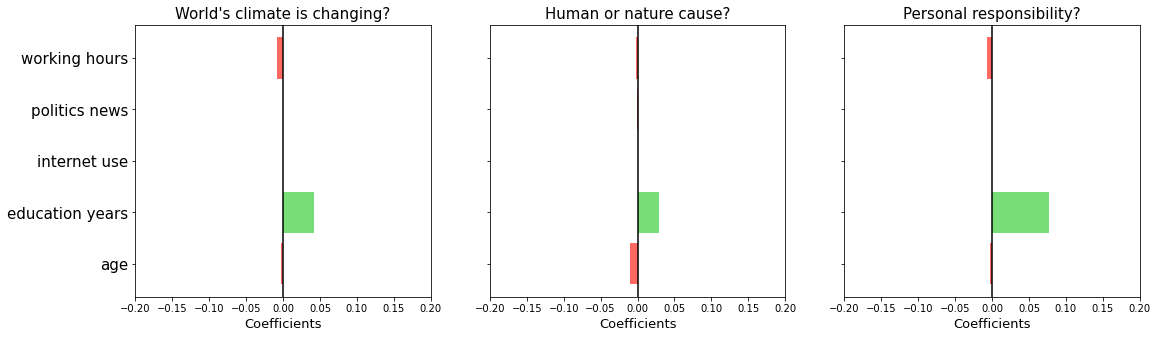

In [25]:
#build a subplot structure
fig, axs = plt.subplots(1,3,figsize=(18,5))
#define lists used in the loop
df_list = [df_reg_cc,df_reg_ch,df_reg_pr]
y_list = ['clmchng','ccnthum','ccrdprs']
title_list = ["World's climate is changing?","Human or nature cause?","Personal responsibility?"]

for d,df_plotted in enumerate(df_list):

    #define the predictor matrix X containing 5 variables: 'age', 'education years', 'internet use', 'politics news', 'working hours'
    X = df_plotted.drop(columns=['clmchng','ccnthum','ccrdprs'])
    X = X.apply(lambda col: col.fillna(col.mean()))

    #define the dependent variable as one of the variable of interest
    y = df_plotted[y_list[d]]

    #split in train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    #initialize and fit the ordered logistic model
    mod_prob = OrderedModel(y_train,X_train, distr='logit')
    res_prob_pr = mod_prob.fit(method='bfgs')

    #define how many predictors 
    n_ind_vars = 5

    #extract coefficients from summary table
    sum = res_prob_pr.summary()
    tcoeff = sum.tables[1]
    coeffs = []
    for row in tcoeff.data:
        coeffs.append(row[1])

    #convert coefficients into a numpy array
    coeff_array = np.array(coeffs)[1:n_ind_vars+1].astype(float)

    #define colors relative to the positive coff (green) or negative coeff (red)
    col_bars = []
    for col in coeff_array:
        if col >0:
            col_bars.append("#77DD76")
        else:
            col_bars.append("#FF6962")

    #plot three horizontal bar charts
    axs[d].barh(y=list(range(len(coeff_array))), width=coeff_array, color=col_bars)
    axs[d].set_yticks(range(n_ind_vars))
    if d == 0:
        axs[d].set_yticklabels(['age', 'education years', 'internet use', 'politics news', 'working hours'], fontsize=15)
    else:
        axs[d].set_yticklabels([])
    axs[d].set_xlim([-0.2,0.2])
    axs[d].set_xlabel("Coefficients", fontsize=13)
    axs[d].axvline(0, color="black");
    axs[d].set_title(title_list[d], fontsize=15)
